# Generalized Linear Model

In GLM, we try to generalize linear model such that error term no longer need to be normally distrbuted. GLM extends from traditional linear regression model under the following 2 conditions

1. $Y|X \sim$ some exponential family distribution
2. a link function is mapped to the conditional expectation for compatibility $g(\mu) = X^T\beta$

A subset of exponential family distribution is called the Canonical exponential family, its pdf is represented by 

$$f_{\theta}(y) = exp(\frac{y\theta-b(\theta)}{\phi}+c(y, \phi))$$

where $b(\theta)$ is the cumulant generating function

This give us a connected link between different functions

- $b'(\theta) = \mu$
- $\mu = g^{-1}(X^T\beta)$
- $\theta = b'^{-1}(g^{-1}(X^T\beta)) = h(X^T\beta)$

as well as the log likelihood
$$l_n(\beta, \phi;Y,X) = \sum_i\frac{Y_ih(X^T\beta)-b(h(X^T\beta))}{\phi}$$

Notice that b is a convex function (b''>0), this makes the log likelihood function above a concave function (linear - convex = concave)

We can run optimization in different ways

1. **Newton Raphson (quadratic approximation)**
$$\beta^{(k+1)} = \beta^{(k)}-H_{l_n}(\beta^{(k)})^{-1}\nabla_{l_n}(\beta^{(k)})$$
- problem with this is the inverse of hessian is expensive to compute

2. **Fisher Scoring**
$$E_\theta[H_{l_n}(\theta)] = -I(\theta)$$
- we use the idea that expectation of hessian is negative fisher information
- notice that for canonical exponential family, the hessian is same as fisher information
$$\beta^{(k+1)} = \beta^{(k)}+I(\beta^{(k)})^{-1}\nabla_{l_n}(\beta^{(k)})$$

3. **Iteratively Re-weighted Least Square (IRLS)**
$$\beta^{(k+1)} = \beta^{(k)} + (X^TWX)^{-1}X^TW(\tilde{Y}-\tilde{\mu})$$
$$\beta^{(k+1)} = (X^TWX)^{-1}X^TW(\tilde{Y}-\tilde{\mu}+X\beta^{k})$$

- where $W_i = \frac{h'(X^T\beta)}{g'(\mu)\phi}$

# Demonstrated example using Logistic Regression -> Logit Link

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  

np.random.seed(42)

n_samples = 1000
n_features = 2

X = np.random.randn(n_samples, n_features)

true_beta = np.array([1.0, -0.5, 0.8])  # [intercept, beta1, beta2]

X = np.column_stack([np.ones(n_samples), X])

linear_pred = X @ true_beta

probabilities = expit(linear_pred)

Y = np.random.binomial(1, probabilities)
Y = Y.reshape(1,len(Y)).T
beta = np.array([[0.5,1,1]]).T

In [91]:
print('beta shape: ', beta.shape)
print('Y shape: ', Y.shape)
print('X shape: ', X.shape)

beta shape:  (3, 1)
Y shape:  (1000, 1)
X shape:  (1000, 3)


## Pure Newton Raphson Update

In [ ]:
beta = np.array([[0], [0], [0]])  
new_beta = np.array([[0.5], [1], [1]])  

for _ in range(100):
    beta = new_beta.copy()
    
    # Linear predictor and probabilities
    eta = X @ beta  # (n,1)
    p = expit(eta)  # (n,1)
    
    # Gradient: (Y-p)X
    grad = X.T @ (Y - p)  # (p,1)
    
    # Hessian: p(1-p)XX
    W = (p * (1 - p)).flatten()  # (n,) weights
    hessian = -X.T @ (W[:, np.newaxis] * X)  # (p,p)
    
    # Newton-Raphson update: new beta = old beta - hession @ gradient
    try:
        hessian_inv = np.linalg.inv(hessian)
        new_beta = beta - hessian_inv @ grad 
    except np.linalg.LinAlgError:
        # Hessian is singular, add small regularization
        hessian_inv = np.linalg.inv(hessian + 1e-6 * np.eye(hessian.shape[0]))
        new_beta = beta - hessian_inv @ grad
beta = new_beta

## Iteratively Reweighted Least Squares (IRLS)

In [113]:
import numpy as np
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def irls_logistic_regression(X, Y, max_iter=100, tol=1e-6, verbose=True):
    """
    Iteratively Reweighted Least Squares (IRLS) for logistic regression
    
    Parameters:
    X: design matrix (n_samples, n_features) - should include intercept column
    Y: target vector (n_samples,) or (n_samples, 1) - binary 0/1
    max_iter: maximum number of iterations
    tol: convergence tolerance
    
    Returns:
    beta: estimated coefficients
    history: dict with iteration history
    """
    
    # Ensure Y is a column vector
    if Y.ndim == 1:
        Y = Y.reshape(-1, 1)
    
    n, p = X.shape
    
    # Initialize beta (can use zeros or small random values)
    beta = np.zeros((p, 1))
    
    history = {
        'beta': [beta.copy()],
        'deviance': [],
        'iterations': 0
    }
    
    for iteration in range(max_iter):
        # Linear predictor
        eta = X @ beta
        
        # Probabilities
        p = expit(eta)
        
        # Avoid numerical issues
        p = np.clip(p, 1e-10, 1 - 1e-10)
        
        # Weight matrix (diagonal)
        W_diag = (p * (1 - p)).flatten()
        
        # Working response
        z = eta + (Y - p) / W_diag.reshape(-1, 1)
        
        # Weighted Least Squares solution
        # beta_new = (X^T W X)^{-1} X^T W z
        
        #Apply normal equations 
        XtWX = X.T @ (W_diag[:, np.newaxis] * X)
        XtWz = X.T @ (W_diag[:, np.newaxis] * z)
        
        try:
            beta_new = np.linalg.solve(XtWX, XtWz)
        except np.linalg.LinAlgError:
            # Add small regularization if singular
            XtWX_reg = XtWX + 1e-8 * np.eye(p)
            beta_new = np.linalg.solve(XtWX_reg, XtWz)
        
        # Calculate deviance (-2 * log-likelihood) for monitoring
        deviance = -2 * np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))
        history['deviance'].append(deviance)
        
        # Check convergence
        change = np.sum(np.abs(beta_new - beta))
        if verbose and iteration % 10 == 0:
            print(f"Iter {iteration:3d}, Deviance: {deviance:.6f}, Change: {change:.6e}")
        
        if change < tol:
            beta = beta_new
            if verbose:
                print(f"Converged after {iteration + 1} iterations")
            break
        
        beta = beta_new
        history['beta'].append(beta.copy())
        history['iterations'] = iteration + 1
    
    return beta.flatten(), history

# Alternative implementation using np.linalg.lstsq (more numerically stable)
def irls_logistic_regression_lstsq(X, Y, max_iter=100, tol=1e-6):
    """IRLS using lstsq for better numerical stability"""
    
    if Y.ndim == 1:
        Y = Y.reshape(-1, 1)
    
    n, p = X.shape
    beta = np.zeros((p, 1))
    
    for iteration in range(max_iter):
        eta = X @ beta
        p = expit(eta)
        p = np.clip(p, 1e-10, 1 - 1e-10)
        
        W_diag = (p * (1 - p)).flatten()
        z = eta + (Y - p) / W_diag.reshape(-1, 1)
        
        # Weighted least squares using lstsq
        W_sqrt = np.sqrt(W_diag).reshape(-1, 1)
        X_weighted = W_sqrt * X
        z_weighted = W_sqrt * z
        
        beta_new, _, _, _ = np.linalg.lstsq(X_weighted, z_weighted, rcond=None)
        beta_new = beta_new.reshape(-1, 1)
        
        if np.sum(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        
        beta = beta_new
    
    return beta.flatten()

## Compare with sklearn logistic regression library

Iter   0, Deviance: 1386.294361, Change: 1.954765e+00
Converged after 6 iterations

Coefficient Comparison:
True coefficients:       [ 0.5  1.  -0.8  0.3]
IRLS coefficients:       [ 0.61688366  0.97758938 -0.91104514  0.28050735]
sklearn coefficients:    [ 0.61687949  0.97759874 -0.91106357  0.28046855]
IRLS - True diff:        [ 0.11688366 -0.02241062 -0.11104514 -0.01949265]
IRLS - sklearn diff:     [ 4.17104169e-06 -9.35745602e-06  1.84352199e-05  3.88006917e-05]


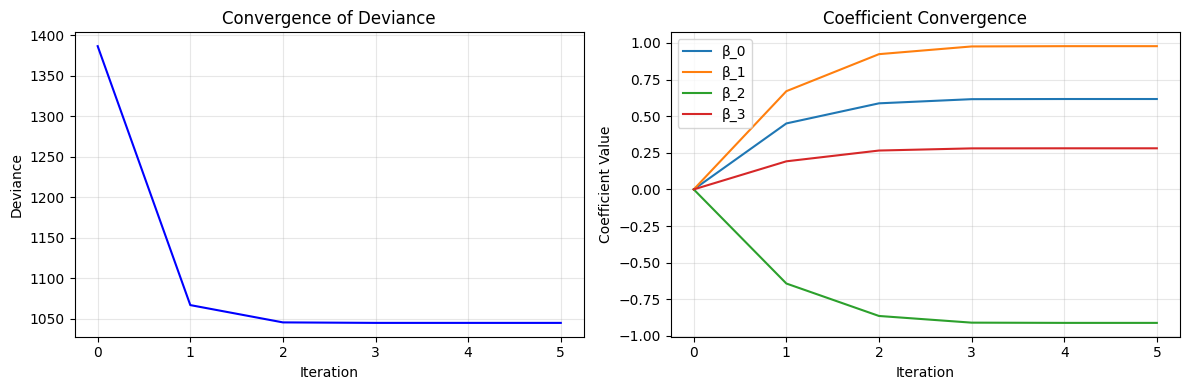

In [112]:
# Generate synthetic data
np.random.seed(42)
n_samples = 1000
n_features = 3
true_beta = np.array([0.5, 1.0, -0.8, 0.3])  
X = np.random.randn(n_samples, n_features)
X_with_intercept = np.column_stack([np.ones(n_samples), X])

# Generate responses
eta = X_with_intercept @ true_beta
p_true = expit(eta)
Y = (np.random.random(n_samples) < p_true).astype(int)

# Run IRLS
beta_irls, history = irls_logistic_regression(X_with_intercept, Y, verbose=True)

# Compare with sklearn
sklearn_model = LogisticRegression(fit_intercept=False, C=1e9, solver='lbfgs', max_iter=1000)
sklearn_model.fit(X_with_intercept, Y)
beta_sklearn = sklearn_model.coef_.flatten()

print("\n" + "="*50)
print("Coefficient Comparison:")
print(f"True coefficients:       {true_beta}")
print(f"IRLS coefficients:       {beta_irls}")
print(f"sklearn coefficients:    {beta_sklearn}")
print(f"IRLS - True diff:        {beta_irls - true_beta}")
print(f"IRLS - sklearn diff:     {beta_irls - beta_sklearn}")

# Plot convergence
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['deviance'], 'b-')
plt.xlabel('Iteration')
plt.ylabel('Deviance')
plt.title('Convergence of Deviance')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
history_beta = np.array(history['beta']).squeeze()
for i in range(history_beta.shape[1]):
    plt.plot(history_beta[:, i], label=f'β_{i}')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()